In [6]:
from datetime import datetime
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 2.0 Exploratory Weather Data Analysis
This analysis will use daily weather data created in [part one](#).  Part of this analysis will focus on both temperature and precipitation values  in order to better quantify the "missingness" of the data produced by weather stations in London Ontario and to identify relationships between weather and precipitation.  Ultimately, we are most interested in analyzing precipitation values and trends and less interested in weather statistics.

## 2.1 Data Prep
The preperatory phase in [1.0](#) included transformations to create daily observational data by averaging observations from multiple sensors (weather stations).  The data prepertation here consists of:

  1. Loading the data
  2. Creating new fields that capture the year and month of the observations, making the data easier to aggregate (group)
  3. Creating a seasonal indicator field that captures the season in which the observation was made

### Data

In [7]:
df = pd.read_csv("../data/notebook1_weather_by_day_2017-07-21.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 12 columns):
date                  2759 non-null object
maxTemp               2758 non-null float64
minTemp               2759 non-null float64
meanTemp              2758 non-null float64
heatDegDays           2758 non-null float64
coolDegDays           2758 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2720 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1953 non-null float64
dtypes: float64(11), object(1)
memory usage: 258.7+ KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN


### Dates

In [8]:
df['date'] = pd.to_datetime(df['date'])

Add date components as separate columns so we can subset the data more easily

In [9]:
df.loc[:, 'year'] = df['date'].apply(lambda x: x.year)
df.loc[:, 'month'] = df['date'].apply(lambda x: x.month)
df.head()

,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,year,month
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN,2010,1
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN,2010,1
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN,2010,1
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN,2010,1
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN,2010,1


### Seasons
Adding a seasonal indicator will allow us to visualize seasonal weather effects (if any).  Seasonal bounds for the Northern hemisphere are used to label each observation below
> [...] for temperate areas in the northern hemisphere, spring begins on 1 March, summer on 1 June, autumn on 1 September, and winter on 1 December. - [Wikipedia](https://en.wikipedia.org/wiki/Season#Meteorological).

In [10]:
def season(date):
  if date.month == 12 or date.month < 3:
    # December - Feb
    return 'winter'
  elif date.month >= 3 and date.month < 6:
    # March - June
    return 'spring'
  elif date.month >= 6 and date.month < 9:
    # June - Sept
    return 'summer'
  else:
    # Sept - Nov
    return 'fall'

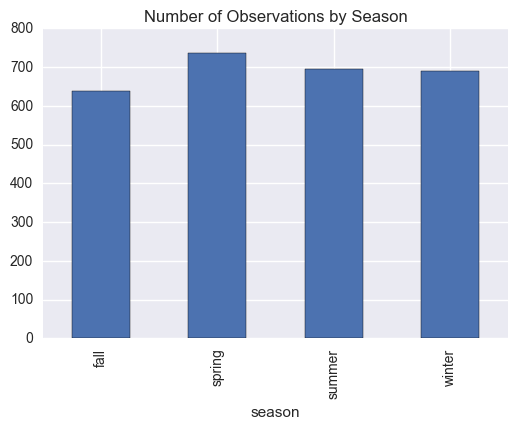

In [11]:
df['season'] = df.date.apply(season)
g = df.groupby('season').size().plot(kind='bar')
_ = g.set_title("Number of Observations by Season")

## 2.2 Missing Value Analysis

### Missing values by variable

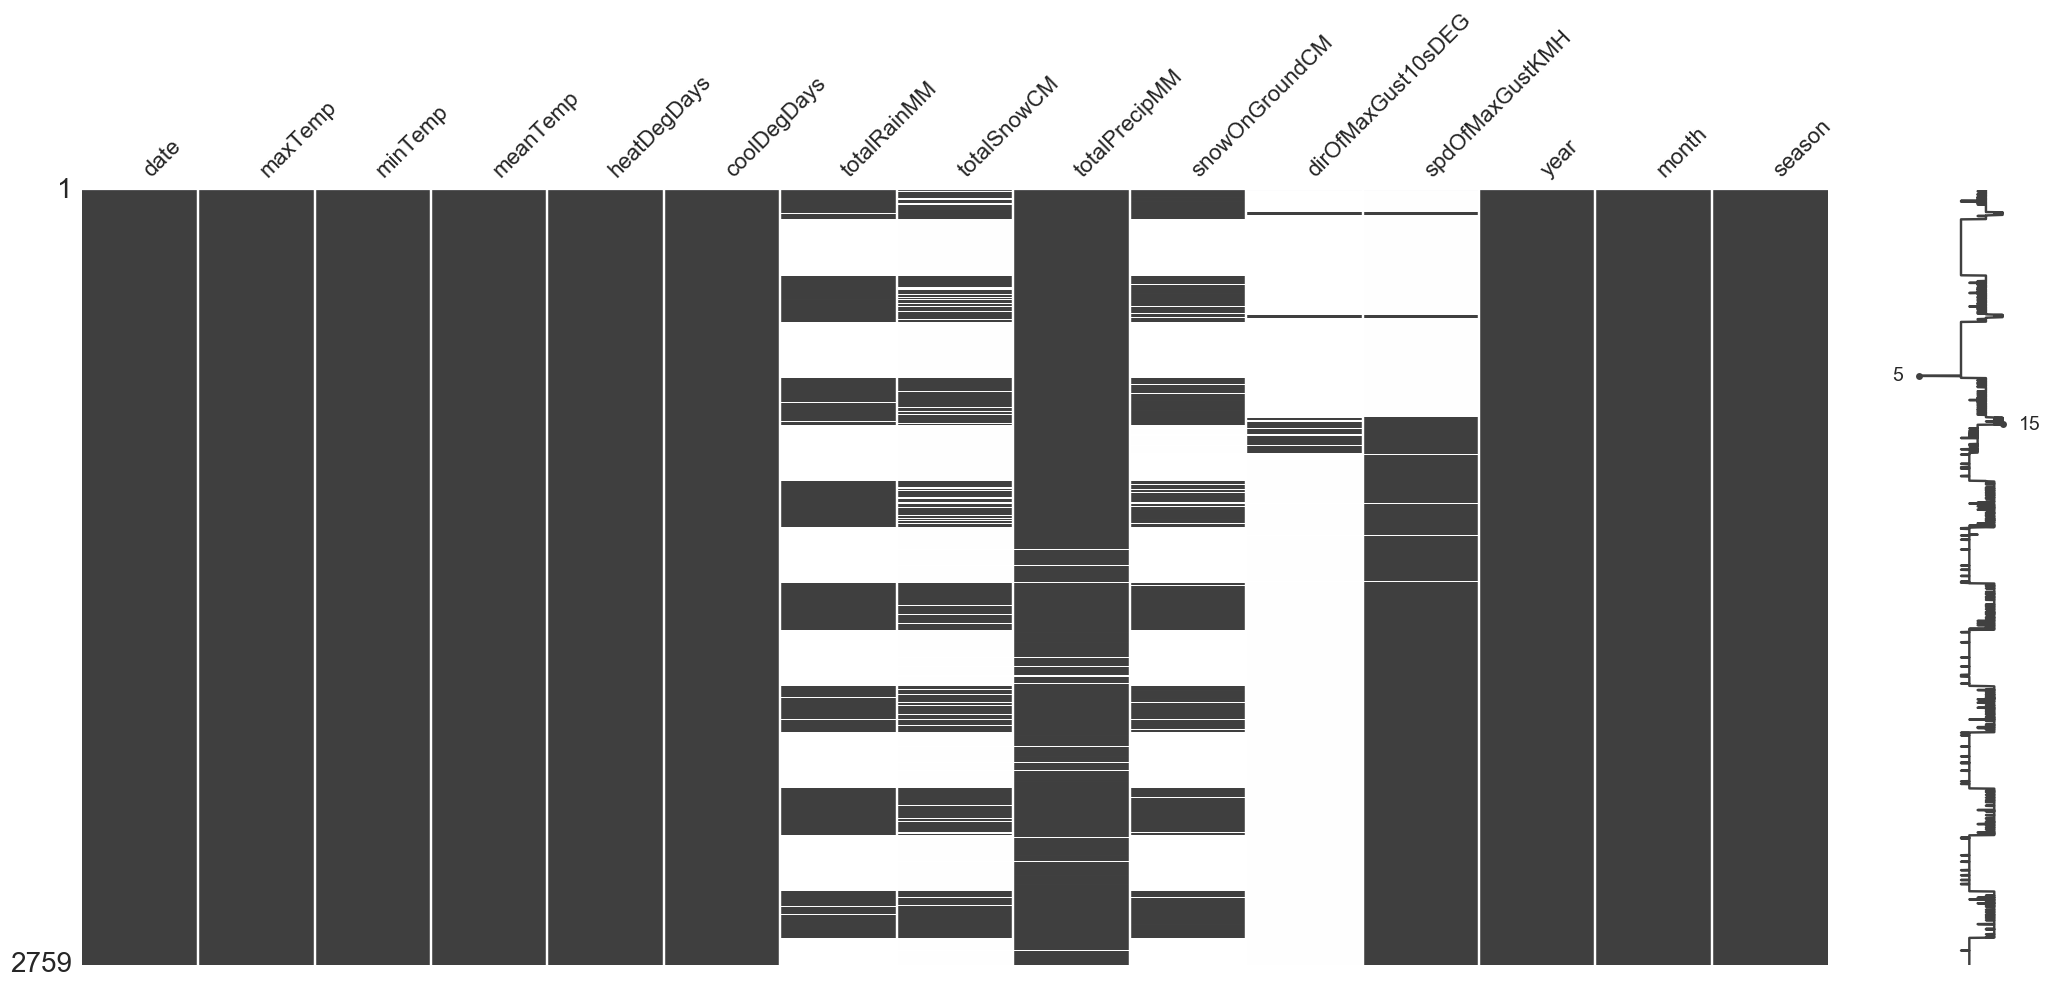

In [12]:
msno.matrix(df.sort_values('date', ascending=True))

In [23]:
max_missing_vars = df.isnull().sum(axis=1).sort_values(ascending=False).values[0]
max_missing_day = df.loc[df.isnull().sum(axis=1).sort_values(ascending=False).head(1).index, 'date'].values[0]
max_missing_day_perc = int(round(max_missing_vars / len(df.columns) * 100, 0))
print("Number of variables: %s" % len(df.columns))
print("Highest number of missing values: %s" % max_missing_vars)
print("Highest % of missing measurements: {}".format(max_missing_day_perc))
print("Day with highest number of missing values: %s" % pd.to_datetime(max_missing_day).date())

Number of variables: 15
Highest number of missing values: 10
Highest % of missing measurements: 67
Day with highest number of missing values: 2011-10-24


Out of {{len(df)}} observations, the maximum number of missing values for a day is {{max_missing_vars}} ({{max_missing_day_perc}}% of the variables) which was observed on {{str(pd.to_datetime(max_missing_day).date())}}.  We can safely ignore this single missing observation.

Rainfall looks to be systematically missing but other variables look okay.  Since the data is sorted by the date column in the matrix show above, it's obvious that rainfall data is missing _periodically_.  We can plot the values over time to get a better look at the missing rainfall data.

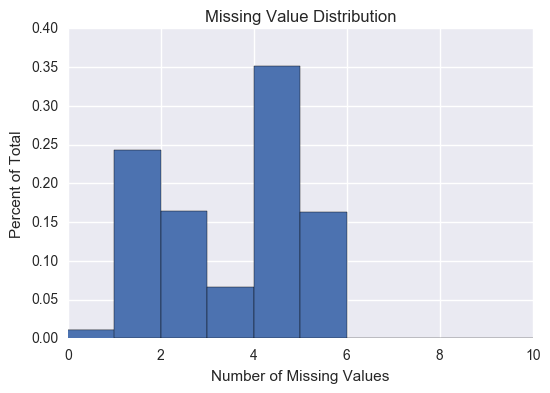

In [12]:
plt.hist(df.isnull().sum(axis=1), weights=np.zeros(len(df)) + 1. / len(df))
plt.title("Missing Value Distribution");
plt.xlabel("Number of Missing Values");
plt.ylabel("Percent of Total");

Approximately half of the rows are missing 2-6 observations. 

### Missing rainfall trends

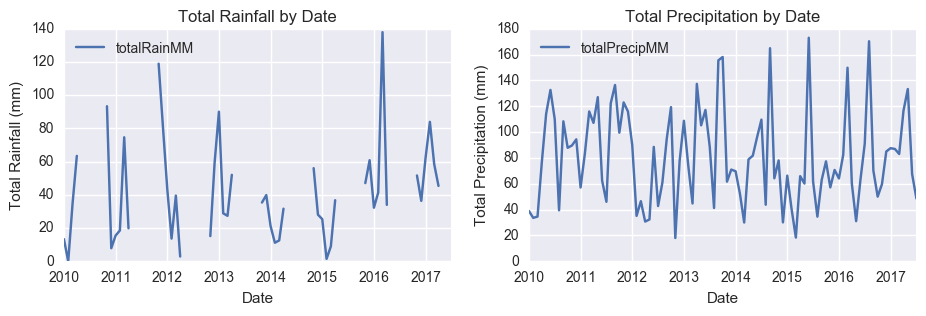

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(11,3))
# Total rainfall
df[['date', 'totalRainMM']].set_index('date').resample('1M').sum().plot(ax=ax1);
ax1.set_title("Total Rainfall by Date")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Rainfall (mm)");
# Total precipitation
df[['date', 'totalPrecipMM']].set_index('date').resample('1M').sum().plot(ax=ax2);
ax2.set_title("Total Precipitation by Date")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Precipitation (mm)");

The graph on the left shows that rainfall data is systematically missing for mid-year months.  From the graph on the right, we can begin to see how precipitation in 2016 and 2017 has been higher, on average compared to previous years.  It is also evident that there is a positive trend from ~ Feb 2015 to July 2017.

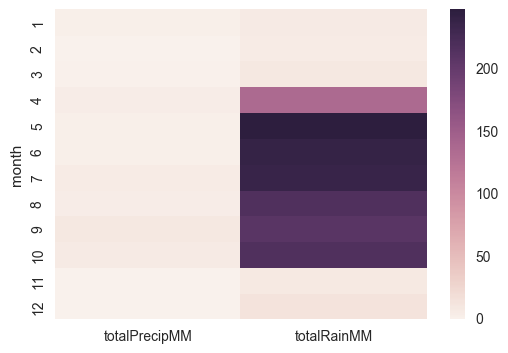

In [25]:
d = df[['month', 'totalPrecipMM', 'totalRainMM']].groupby(['month'])[['totalPrecipMM', 'totalRainMM']]
d = d.apply(lambda x: pd.isnull(x).sum())
sns.heatmap(d);

April through October is missing rain measurements year-over-year.  This isn't a big deal since any observed precipitation in this period is likely rain.

## 2.3 Multivariate Data Analysis
We'll look at the distributions of each variable simultaneously to evaluate distributions and relationships.  The table below describes statistical properties of the daily weather observations and the pair plot visualizes marginal and conditional distributions of the continuous (numerical) observations.

In [27]:
cont_vars = [
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
df[cont_vars].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
minTemp,2759.0,3.423215,10.081919,-29.65,-3.3,3.500,11.7000,24.6
meanTemp,2758.0,8.394652,10.702823,-23.85,0.2,8.975,17.6875,30.7
maxTemp,2758.0,13.351994,11.609987,-18.90,3.6,14.550,23.7500,36.7
totalPrecipMM,2720.0,2.702463,6.161120,0.00,0.0,0.100,2.3500,69.7
totalRainMM,1208.0,1.585596,4.502499,0.00,0.0,0.000,0.2000,39.3


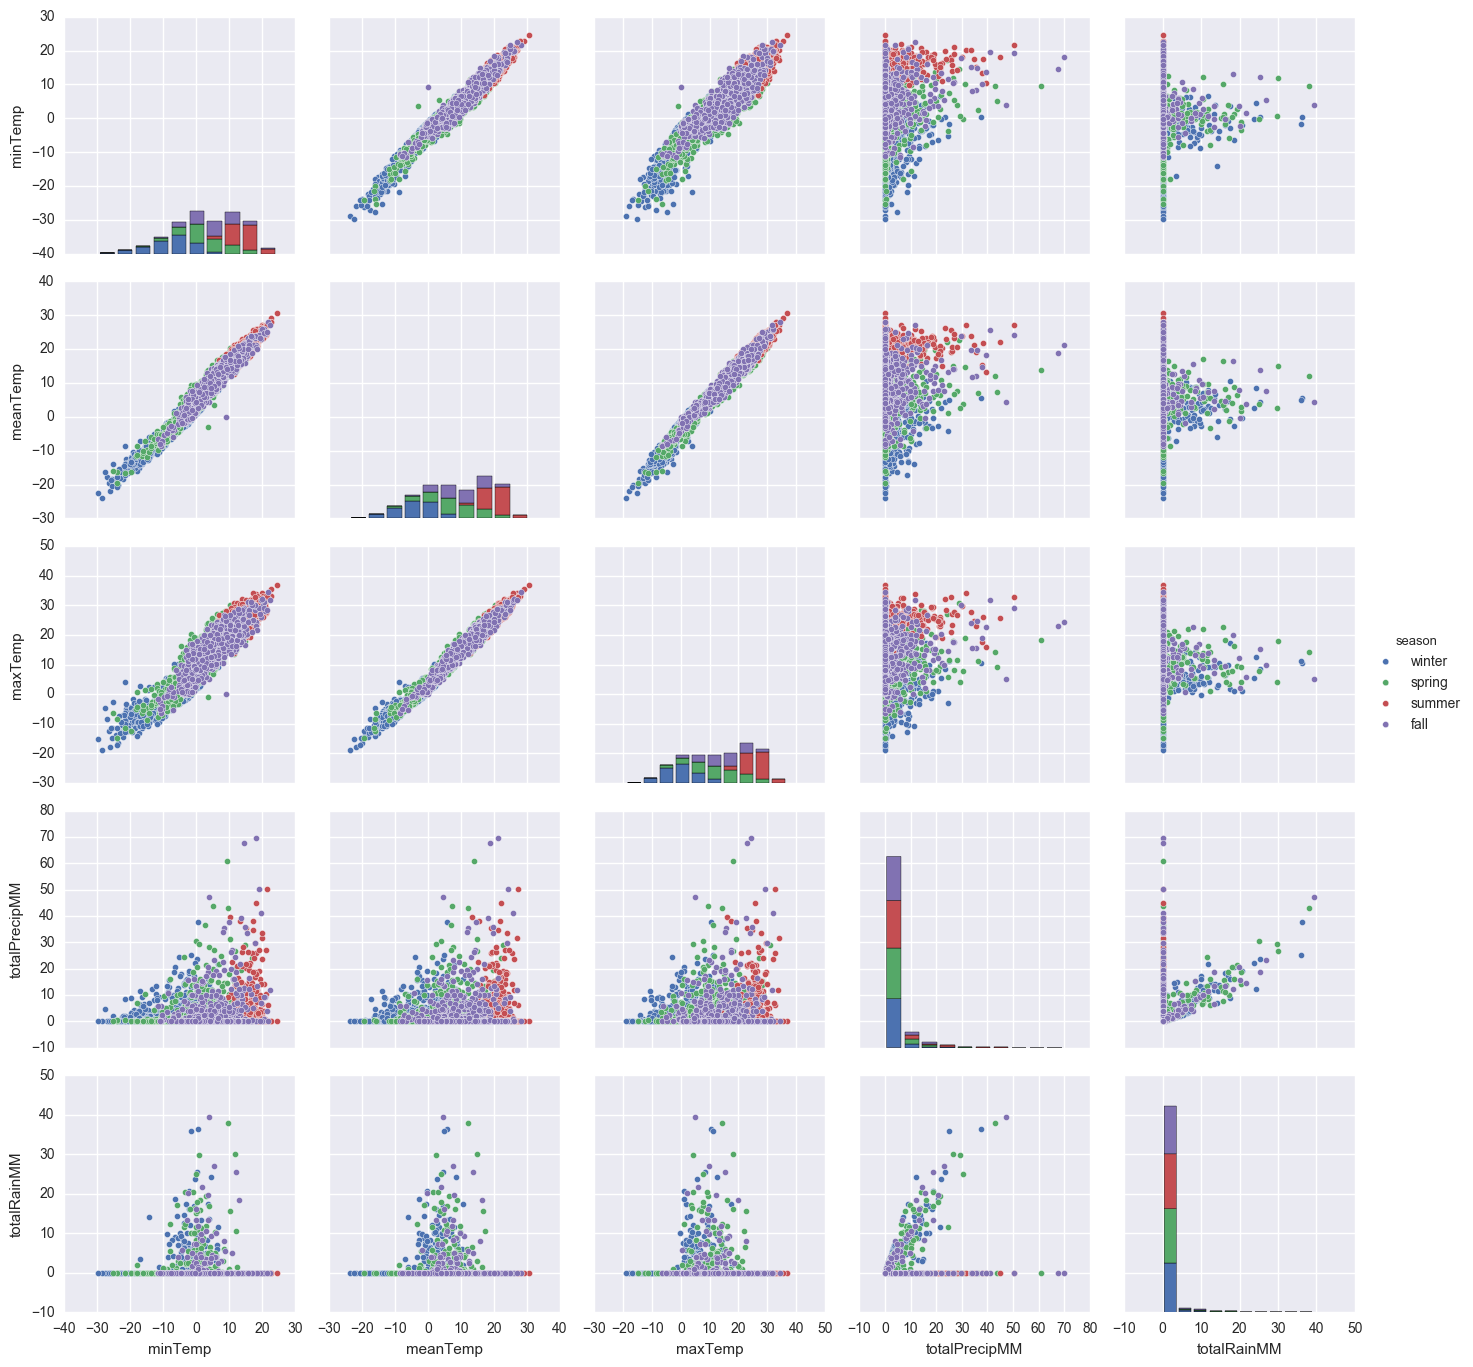

In [28]:
sns.pairplot(df[cont_vars].fillna(0), hue='season', size=2.75);

* As you would expect, temperature distributions are bimodal which account for the different seasons and are highly correlated and fall and spring share significant overlap with summer and winter temperatures while summer and winter temperatures share minimal overlap
* Precipitation appears to be positively correlated with temperature/season

### Temperature and precipitation

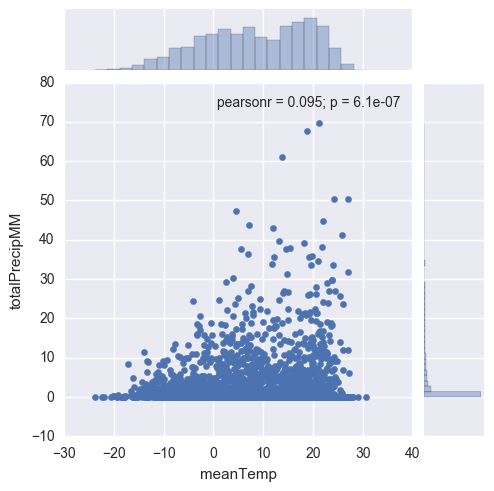

In [29]:
sns.jointplot(x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']], size=5);

Plot without zeros

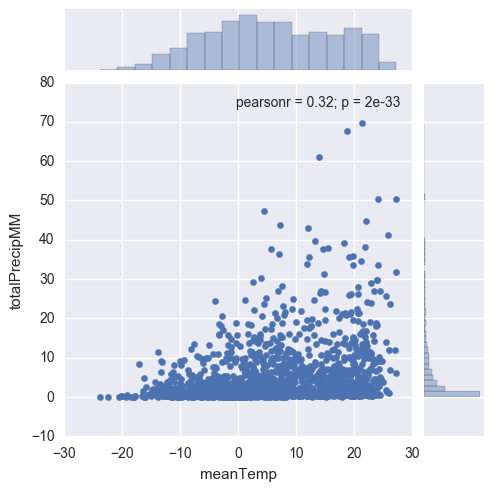

In [31]:
sns.jointplot(
  x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']].query('totalPrecipMM != 0'), size=5);

### Seasonal distributions

#### Relationship between _winter and summer_ temperatures

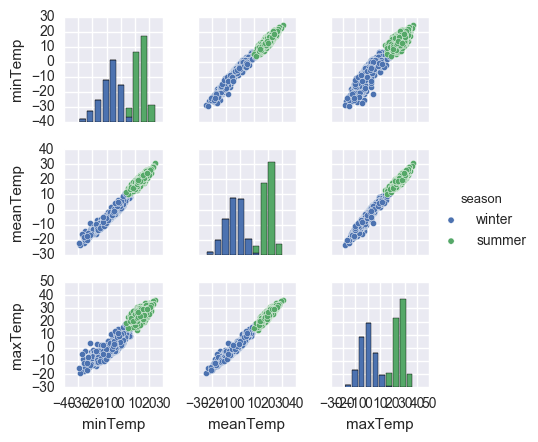

In [32]:
cols = [
#   'month',
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
#   'totalPrecipMM',
#   'totalRainMM'
]
g = sns.pairplot(df.loc[df.season.isin(['winter', 'summer']), cols].fillna(0), hue='season', size=1.5);

There is a clear boundary between temperature values - the values cluster into two normal distributions with minimal overlap

#### Relationship between _fall and winter_ temperatures

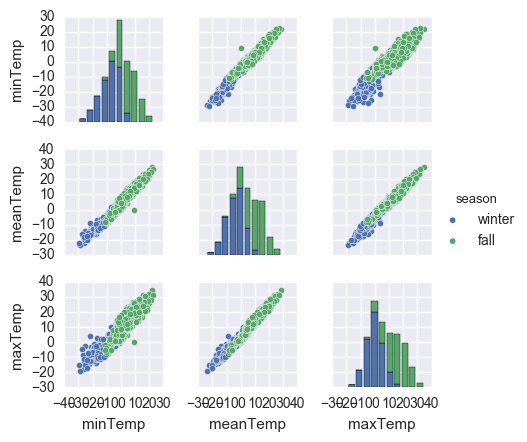

In [33]:
cols = [
#   'month',
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
#   'totalPrecipMM',
#   'totalRainMM'
]
g = sns.pairplot(df.loc[df.season.isin(['fall', 'winter']), cols].fillna(0), hue='season', size=1.5);

#### Relationship between _winter and spring_ temperatures

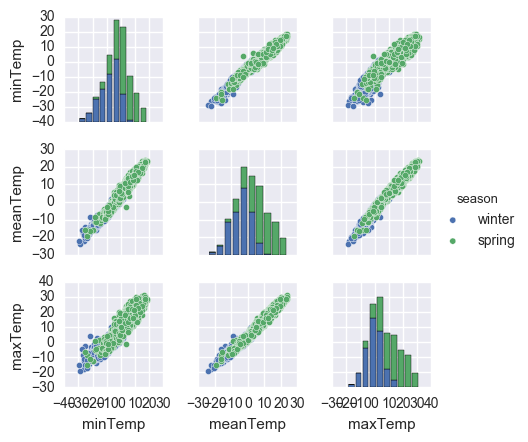

In [34]:
sns.pairplot(df.loc[df.season.isin(['winter', 'spring']), cols].fillna(0), hue='season', size=1.5);

#### Relationship between _spring and summer_ temperatures

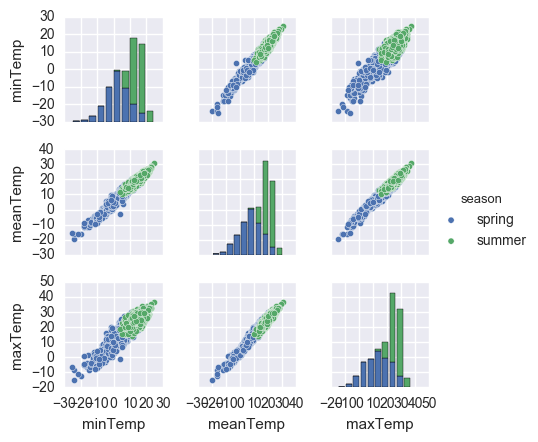

In [35]:
sns.pairplot(df.loc[df.season.isin(['spring', 'summer']), cols].fillna(0), hue='season', size=1.5);

#### Relationship between _spring and fall_ temperatures

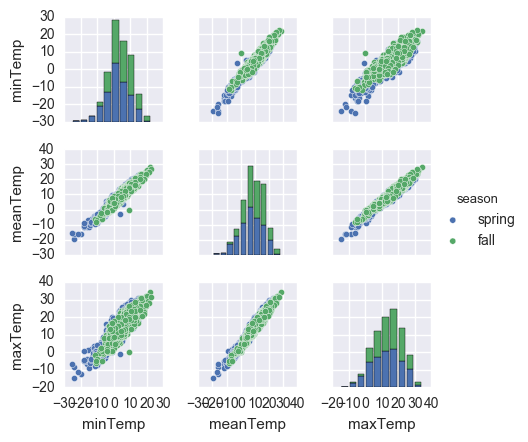

In [36]:
sns.pairplot(df.loc[df.season.isin(['spring', 'fall']), cols].fillna(0), hue='season', size=1.5);

As expected, spring and fall overlap significantly with each other and winter and summer seasons.  What about the rain and precipitation?

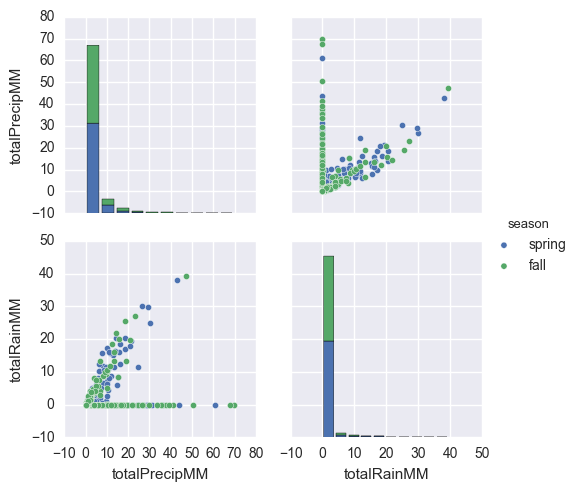

In [20]:
cols = [
#   'month',
  'season',
#   'minTemp',
#   'meanTemp',
#   'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
sns.pairplot(df.loc[df.season.isin(['fall', 'spring']), cols].fillna(0), hue='season');

## 2.4 Precipitation Changes Over Time
At this point, we'll only visualize precipitation changes since we are missing significant rainfall data as show above.  In order to more accurately answer the question "has it rained more this year than last", we can use inference to generate rainfall data (i.e. use a predictive model to estimate the rainfall for the missing months).  While we won't further investigate it here (see the next [workbook](#)), it should be noted that inference will be difficult since we've never directly observed the months we are trying to estimate.

The following visualizations describe how precipitation (and thus how rainfall) changes over time.

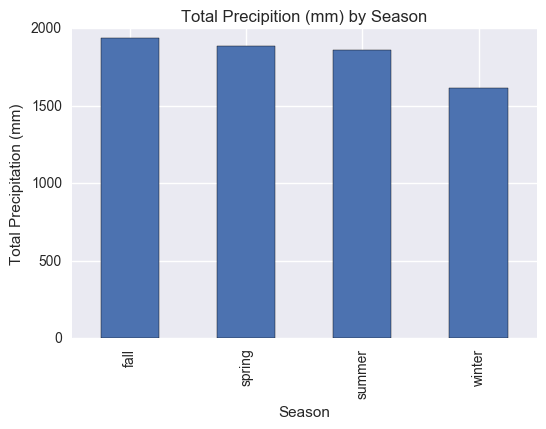

In [21]:
g = df.groupby('season').totalPrecipMM.sum().plot(kind='bar');
g.set_title("Total Precipition (mm) by Season");
g.set_xlabel("Season");
g.set_ylabel("Total Precipitation (mm)");

Total precipitation stays stable accross seasons.  What about accross years?

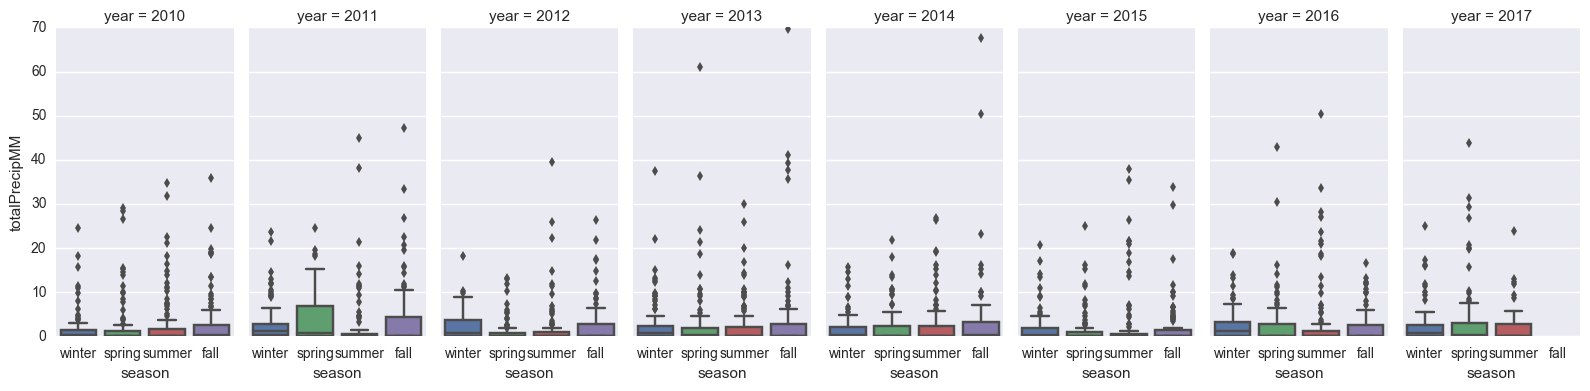

In [38]:
sns.factorplot(x="season", y="totalPrecipMM",
               col="year", data=df, kind="box", size=4, aspect=.5);

It looks like the variation stays roughly constant over time.  We could test this but it's not the focus of this analysis.  We're more interested in changes from 2017 to other years.

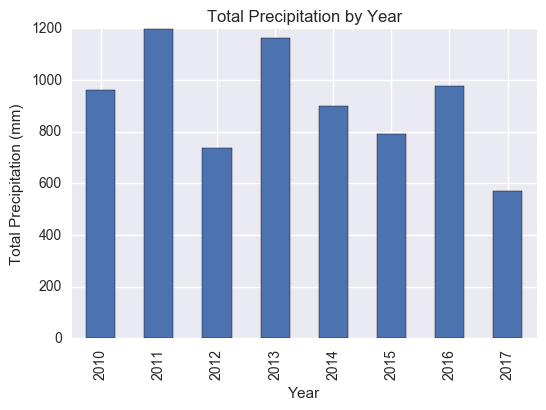

In [23]:
_ = df.groupby('year').totalPrecipMM.sum().plot(kind='bar');
_.set_title("Total Precipitation by Year")
_.set_xlabel("Year");
_.set_ylabel("Total Precipitation (mm)");

We should only consider YTD values since the year isn't done yet

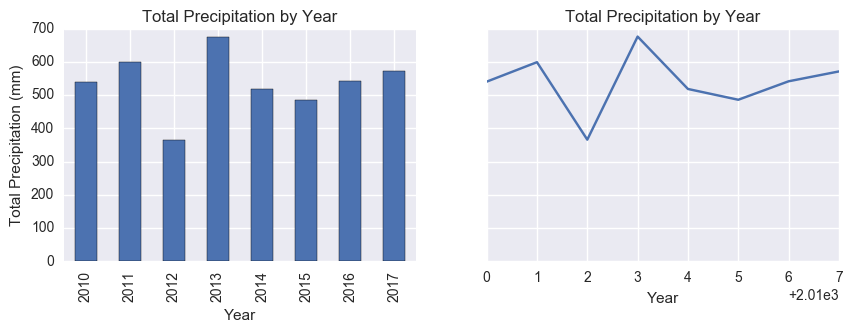

In [34]:
# YTD values
month = datetime.now().month
tot_precip_ytd = df[df.month <= month].groupby('year').totalPrecipMM.sum()

## Figure
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,3))

g = tot_precip_ytd.plot(kind='bar', ax=ax1);
g.set_title("Total Precipitation by Year")
g.set_xlabel("Year");
g.set_ylabel("Total Precipitation (mm)");

g = tot_precip_ytd.plot(kind='line', ax=ax2);
g.set_title("Total Precipitation by Year")
g.set_xlabel("Year");
g.set_ylabel("Total Precipitation (mm)");

Rank the years by total precipitation

In [36]:
tot_precip_ytd.sort_values(ascending=False)

year
2013    676.65
2011    599.60
2017    571.75
2016    542.05
2010    540.90
2014    518.95
2015    486.45
2012    366.30
Name: totalPrecipMM, dtype: float64

We can see that there has been an increase in precipitation over the last three years and so far this year, we've experienced the third highest amount of precipitation since 2010 and have had the most precipitation this year than in the previous three years (2013-2016).  This was also visualized in [Missing rainfall trends](#Missing-rainfall-trends).

#### NOTES
* Normals available at http://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=4789&autofwd=1